# Import Pre-trained Models

In this notebook, we will use the basic functionalities of SecML-Torch to import a pre-trained model from torchvision or a robust model from RobustBench. This demonstrates how SecML-Torch can wrap any PyTorch model, whether it's a standard pre-trained model or one specifically trained for adversarial robustness.

In [ ]:
%%capture --no-stderr 
try:
    import secmlt
except ImportError:
   %pip install secml-torch

In [2]:
%%capture
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision.models import get_model
import matplotlib.pyplot as plt
from torchvision import transforms
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier


#### Loading and Preprocessing an Image

We'll first download a sample image and prepare it for inference. The preprocessing pipeline follows the standard ImageNet preprocessing: resize to 256 pixels, center crop to 224x224, and convert to tensor. These transformations ensure the input matches what the model expects.

In [3]:
%%capture 
%pip install requests

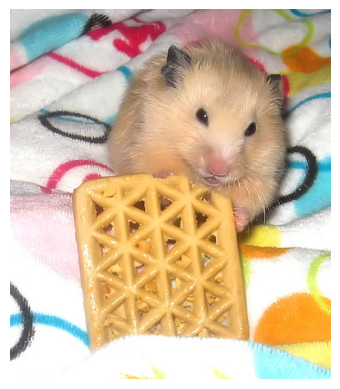

In [4]:
import requests
from PIL import Image
import io
import json

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

img_url = (
    "https://github.com/ajschumacher/imagen/blob/master/imagen/n02342885_10908_hamster.jpg?raw=true"
)
resp = requests.get(img_url)
labels_url = (
    "https://raw.githubusercontent.com/"
    "anishathalye/imagenet-simple-labels/master/"
    "imagenet-simple-labels.json"
)
r = requests.get(labels_url)
imagenet_labels = json.loads(r.text)
img = Image.open(io.BytesIO(resp.content)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.show()

input_tensor = transform(img)

#### Importing a Pre-trained Model from Torchvision

Now we'll load a pre-trained Vision Transformer (ViT) model from torchvision. The model has been trained on ImageNet-1K and expects images preprocessed as shown above. We wrap it with `BasePytorchClassifier` to integrate it with SecML-Torch's functionality.

In [5]:
%%capture
net = get_model("vit_b_16", weights="IMAGENET1K_V1")
device = "cpu"
net.to(device)

model = BasePytorchClassifier(net)

#### Making Predictions

Let's use the wrapped model to classify our image. The `predict` method handles the forward pass and returns the predicted class index. We'll map this to the human-readable ImageNet label.

In [6]:
pred = model.predict(input_tensor.unsqueeze(0).to(device))
predicted_label = imagenet_labels[pred.item()]
print(f"Predicted class index: {pred.item()}")
print(f"Predicted class label: {predicted_label}")

Predicted class index: 333
Predicted class label: hamster


#### Loading a Robust Model from RobustBench

RobustBench provides models that have been trained to be robust against adversarial attacks. Here we load a model that's robust to L∞ perturbations. Notice that despite being a specialized robust model with additional components, we can wrap it with `BasePytorchClassifier` just like any other PyTorch model.

Before using models from RobustBench, we need to install the RobustBench package and its dependencies.

In [7]:
%%capture
%pip install git+https://github.com/RobustBench/robustbench.git

In [8]:
%%capture
from robustbench.utils import load_model
robust_net = load_model(model_name="Salman2020Do_R18", dataset="imagenet", threat_model="Linf")
device = "cpu"
robust_net.to(device)

robust_model = BasePytorchClassifier(robust_net)

#### Comparing Predictions

Let's see if the robust model makes the same prediction on our clean image. Robust models sometimes sacrifice clean accuracy for adversarial robustness, but on this example both models should agree.

In [9]:
pred = robust_model.predict(input_tensor.unsqueeze(0).to(device))
predicted_label = imagenet_labels[pred.item()]
print(f"Predicted class index: {pred.item()}")
print(f"Predicted class label: {predicted_label}")

Predicted class index: 333
Predicted class label: hamster


### Summary

In this tutorial, we've shown how SecML-Torch can seamlessly work with:
- Standard pre-trained models from torchvision
- Specialized robust models from RobustBench

Both types of models are wrapped identically using `BasePytorchClassifier`, providing a unified interface. This becomes particularly useful in later tutorials where we'll attack these models and compare their robustness. The key takeaway is that SecML-Torch works with any PyTorch model, regardless of its architecture or training procedure.